In [20]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import math
from PIL import Image, ImageSequence
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from highlight_text import fig_text, ax_text
import re
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties

# parameters
interpolate = False
interpolate_factor = 10

# pre processing
df = pd.read_csv('global-plastics-production.csv')
df.columns = ['Entity', 'Code', 'Year', 'plastic-production']
df = df.set_index('Year')
df.sort_values(by='Year', inplace=True)
df.drop(['Entity', 'Code'], axis=1, inplace=True)

# add value for missing year 1974
df.loc[1974] = (df.loc[1973].values + df.loc[1975].values) / 2

# predict value with fitting for 2020 up to 2050
X = df.index.values.reshape(-1, 1)
y = df['plastic-production'].values
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X, y)
X_pred = np.arange(2020, 2051).reshape(-1, 1)
y_pred = model.predict(X_pred)
df_pred = pd.DataFrame(y_pred, index=X_pred.flatten(), columns=['plastic-production'])
df = pd.concat([df, df_pred])

# interpolation
if interpolate:
   multiple = interpolate_factor
   new_index = np.linspace(df.index.min(), df.index.max(), len(df) * multiple-(multiple-1))
   df = df.reindex(new_index).interpolate(method='polynomial', order=2)
   df.reset_index(inplace=True)
   df['Year'] = df['index'].astype(int)
   df.index = df['Year']
   df.drop(columns=['index', 'Year'], inplace=True)
   df.index = new_index

df.sort_index(inplace=True)
df.to_csv('global-plastics-production-interpolated.csv', index=False)
df.tail()

,plastic-production
2046,8.925876e+08
2047,9.126693e+08
2048,9.329762e+08
2049,9.535083e+08
2050,9.742655e+08


In [55]:
def remove_unmatched_lt(text):
    pattern = r'<(?![^<>]*>)'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def count_closed_and_enclosed(text):
    closed_pattern = r'<[^<>]*>'
    closed_tags = re.findall(closed_pattern, text)
    return len(closed_tags)

def custom_formatter(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.0f}M'
    elif x >= 1e3:
        return f'{x*1e-3:.0f}k'
    else:
        return f'{x:.0f}'

def draw_arrow(tail_position, head_position, invert=False, radius=0.5):
    kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color=text_color, lw=0.5)
    if invert:
        connectionstyle = f"arc3,rad=-{radius}"
    else:
        connectionstyle = f"arc3,rad={radius}"
    a = FancyArrowPatch(
        tail_position, head_position,
        connectionstyle=connectionstyle,
        transform=ax.transAxes,
        **kw
    )
    ax.add_patch(a)

Original animation finished
Final animation finished!


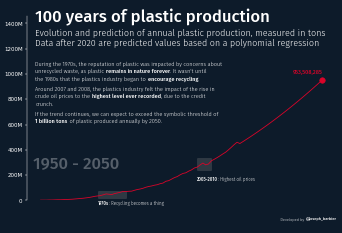

In [54]:
# parameters
background_color = '#0d1b2a'
text_color = 'white'
line_color = '#d90429'
dpi = 40
initial_duration = 60 # 30

# font
personal_path = '/Users/josephbarbier/Library/Fonts/'
font_path = personal_path + 'FiraSans-Light.ttf'
font = FontProperties(fname=font_path)
bold_font = FontProperties(fname=personal_path + 'FiraSans-Medium.ttf')

# description
description = f"""
During the 1970s, the reputation of plastic was impacted by concerns about unrecycled waste, as plastic <remains in nature forever>. It wasn't until the 1980s that the plastics industry began to <encourage recycling>.

Around 2007 and 2008, the plastics industry felt the impact of the rise in crude oil prices to the <highest level ever recorded>, due to the credit crunch. 

If the trend continues, we can expect to exceed the symbolic threshold of <1 billion tons> of plastic produced annually by 2050.
"""

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis='y', colors=text_color)
ax.spines[['left']].set_color(text_color)

# Calculate y-values for the 1970s period
y_1970s = df.loc[1970:1980, 'plastic-production']
ymin_1970s = y_1970s.min()
ymax_1970s = y_1970s.max()

# Calculate y-values for the 2005-2010 period
y_2005_2010 = df.loc[2005:2010, 'plastic-production']
ymin_2005_2010 = y_2005_2010.min()
ymax_2005_2010 = y_2005_2010.max()

# Update function for the animation
def update(frame):

    # skip first frame
    if frame == 0:
        return None

    # initialize subset of data
    subset_df = df.iloc[:frame]
    ax.clear()

    # create the line chart
    ax.plot(subset_df.index, subset_df['plastic-production'], color=line_color)
    ax.scatter(subset_df.index[-1], subset_df['plastic-production'].values[-1], color=line_color, s=100)

    # highlight the 70s
    if 1950 + frame >= 1980:
        rect = ax.axvspan(
            1970, 1980,
            ymin=ymin_1970s*0.3 / subset_df['plastic-production'].max(),
            ymax=ymax_1970s*0.7 / subset_df['plastic-production'].max(),
            color='grey', alpha=0.3,
            zorder=-1
        )
        ax_text(
            1970, ymax_1970s*0.05,
            '<1970s>: Recycling becomes a thing',
            fontsize=8,
            color=text_color,
            ha='left',
            va='top',
            font=font,
            highlight_textprops=[{'font':bold_font}],
            ax=ax
        )

    # highlight the 2005-2010 period
    if 1950 + frame >= 2010:
        rect = ax.axvspan(
            2005, 2010,
            ymin=ymin_2005_2010*0.6 / subset_df['plastic-production'].max(),
            ymax=ymax_2005_2010*0.7 / subset_df['plastic-production'].max(),
            color='grey', alpha=0.3,
            zorder=-1
        )
        ax_text(
            2005, ymax_2005_2010*0.6,
            '<2005-2010>: Highest oil prices',
            fontsize=8,
            color=text_color,
            ha='left',
            va='top',
            font=font,
            highlight_textprops=[{'font':bold_font}],
            ax=ax
        )

    # annotate the last point
    ax_text(
        subset_df.index[-1],
        subset_df['plastic-production'].values[-1]*1.06,
        f"{subset_df['plastic-production'].values[-1]:,.0f}",
        color=line_color,
        fontsize=10,
        ha='right',
        va='center',
        fontproperties=bold_font,
        ax=ax
    )

    # date in the background
    year = df.index[frame]
    fig_text(
        0.14, 0.3,
        '1950 - ' + str(round(year)),
        ha='left', va='top',
        fontsize=30,
        font=bold_font,
        color=text_color,
        fontweight='bold',
        alpha=0.3,
        fig=fig
    )

    # custom axes
    y_min = df.iloc[:frame+1].sum(axis=1).min()
    y_max = df.iloc[:frame+1].sum(axis=1).max()
    ax.set_ylim(0, y_max*1.5)
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

    # get text to display at current frame
    total_chars = len(description)
    effective_frame_count = len(df) - 80 # ends 80 frames before the end
    num_chars = math.ceil(total_chars * (frame / effective_frame_count)) if frame < effective_frame_count else total_chars
    current_description = description[:num_chars]
    current_description = remove_unmatched_lt(current_description)
    num_closed_tags = count_closed_and_enclosed(current_description)
    if num_closed_tags > 0:
        highlight_textprops = [{'font':bold_font} for _ in range(num_closed_tags)]
    else:
        highlight_textprops = None
    wrapped_text = '\n'.join([textwrap.fill(paragraph, width=75) for paragraph in current_description.split('\n')])
    fig_text(
        0.147, 0.7,
        wrapped_text,
        ha='left', va='top',
        fontsize=10,
        font=font,
        color=text_color,
        highlight_textprops=highlight_textprops,
        fig=fig
    )

    # title
    text = """
    <100 years of plastic production>
    <Evolution and prediction of annual plastic production, measured in tons>
    <Data after 2020 are predicted values based on a polynomial regression>
    """
    fig_text(
        0.13, 0.92,
        text,
        ha='left', va='top',
        font=font,
        highlight_textprops=[
            {'color':text_color, 'fontsize':30, 'font':bold_font},
            {'color':text_color, 'fontsize':16},
            {'color':text_color, 'fontsize':16},
        ],
        fig=fig
    )

    # credit annotation
    text = """
    Developed by <@joseph_barbier>
    """
    fig_text(
        0.9, 0,
        text,
        ha='right', va='bottom',
        fontsize=7, font=font,
        color=text_color,
        highlight_textprops=[
            {'font':bold_font},
        ],
        fig=fig
    )

# create and save animation
ani = FuncAnimation(fig, update, frames=len(df))
ani.save('global-plastics-production.gif', fps=20)
print('Original animation finished')


# get initial frames
with Image.open('global-plastics-production.gif') as img:
    frames = [frame.copy() for frame in ImageSequence.Iterator(img)]

# set duration of each frame
for i, frame in enumerate(frames):
    frame_duration = initial_duration

    # stay for last date
    if i == len(frames) - 1:
        frame_duration = 1000 # 10000
    frame.info['duration'] = frame_duration

# Save the modified frames as a new GIF
frames[0].save('global-plastics-production-modif.gif', save_all=True, append_images=frames[1:], loop=0)
print('Final animation finished!')